# Guide to preparing omnipose training data

Demonstrates the loading and splitting of the data for training purposes.

In [1]:
# Import required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile
import time
import shutil
from skimage import io
import random

# Ensure omnipose is installed
try:
    import cellpose_omni
    from cellpose_omni import models, io, transforms
    from omnipose.utils import normalize99
    print("Omnipose import successful")
except ImportError:
    print("Error: Omnipose is not installed. Please install it using: pip install cellpose-omni omnipose")
    sys.exit(1)
    
# Set project paths - navigate to project root
project_root = Path(os.getcwd()).parent.parent
data_dir = project_root / 'data'

# Define source data paths
lb_data_dir = data_dir / 'timelapse_data' / 'LB_data'
m9_data_dir = data_dir / 'timelapse_data' / 'M9_data'

# Create output directories
output_dir = data_dir / 'training_data'
for directory in [output_dir]:
    directory.mkdir(exist_ok=True, parents=True)
    
print(f"Project root: {project_root}")
print(f"LB data directory: {lb_data_dir}")
print(f"M9 data directory: {m9_data_dir}")
print(f"Output directory: {output_dir}")

# Check if source directories exist
print(f"\nChecking source directories:")
print(f"LB data exists: {lb_data_dir.exists()}")
print(f"M9 data exists: {m9_data_dir.exists()}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2025-10-14 17:33:15,485 [INFO] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


/Users/lucas/opt/anaconda3/envs/omni_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Omnipose import successful
Project root: /Users/lucas/Documents/GitHub/ECT
LB data directory: /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/LB_data
M9 data directory: /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/M9_data
Output directory: /Users/lucas/Documents/GitHub/ECT/data/training_data

Checking source directories:
LB data exists: True
M9 data exists: True


In [2]:
def load_lb_m9_datasets(lb_data_dir, m9_data_dir):
    """
    Load LB and M9 datasets from their respective directories.
    
    Parameters:
    -----------
    lb_data_dir : Path
        Directory containing LB data (original_images.tif, ground_truth.tif)
    m9_data_dir : Path
        Directory containing M9 data (bf_frames.tif, stacked_masks.tif)
    
    Returns:
    --------
    dict with loaded datasets and metadata
    """
    print("Loading LB and M9 datasets...")
    
    datasets = {}
    
    # Load LB dataset
    lb_images_path = lb_data_dir / 'original_images.tif'
    lb_masks_path = lb_data_dir / 'ground_truth.tif'
    
    if lb_images_path.exists() and lb_masks_path.exists():
        print(f"Loading LB dataset from {lb_images_path}")
        lb_images = tifffile.imread(lb_images_path)
        lb_masks = tifffile.imread(lb_masks_path)
        
        datasets['LB'] = {
            'images': lb_images,
            'masks': lb_masks,
            'n_frames': lb_images.shape[0],
            'shape': lb_images.shape,
            'source': 'LB_data'
        }
        print(f"  LB dataset: {lb_images.shape} images, {lb_masks.shape} masks")
    else:
        print(f"❌ LB dataset not found!")
        return None
    
    # Load M9 dataset
    m9_images_path = m9_data_dir / 'bf_frames.tif'
    m9_masks_path = m9_data_dir / 'stacked_masks.tif'
    
    if m9_images_path.exists() and m9_masks_path.exists():
        print(f"Loading M9 dataset from {m9_images_path}")
        m9_images = tifffile.imread(m9_images_path)
        m9_masks = tifffile.imread(m9_masks_path)
        
        datasets['M9'] = {
            'images': m9_images,
            'masks': m9_masks,
            'n_frames': m9_images.shape[0],
            'shape': m9_images.shape,
            'source': 'M9_data'
        }
        print(f"  M9 dataset: {m9_images.shape} images, {m9_masks.shape} masks")
    else:
        print(f"❌ M9 dataset not found!")
        return None
    
    return datasets

def create_individual_frames(datasets, output_dir):
    """
    Create individual frame files from the loaded datasets.
    
    Parameters:
    -----------
    datasets : dict
        Dictionary containing LB and M9 datasets
    output_dir : Path
        Directory to save individual frames
    """
    print("Creating individual frame files...")
    
    all_frames = []
    
    for medium, data in datasets.items():
        print(f"Processing {medium} dataset...")
        
        images = data['images']
        masks = data['masks']
        n_frames = data['n_frames']
        
        # Create medium-specific directory
        medium_dir = output_dir / medium
        medium_dir.mkdir(exist_ok=True, parents=True)
        
        # Save individual frames
        for i in range(n_frames):
            # Save image
            img_filename = f"{medium}_frame_{i:03d}.tif"
            img_path = medium_dir / img_filename
            tifffile.imwrite(img_path, images[i])
            
            # Save mask
            mask_filename = f"{medium}_frame_{i:03d}_masks.tif"
            mask_path = medium_dir / mask_filename
            tifffile.imwrite(mask_path, masks[i])
            
            all_frames.append({
                'medium': medium,
                'frame_id': i,
                'image_path': img_path,
                'mask_path': mask_path,
                'image_shape': images[i].shape,
                'mask_shape': masks[i].shape
            })
    
    print(f"Created {len(all_frames)} individual frame files")
    return all_frames

def organize_training_data(source_dir, train_dir, test_dir, train_ratio=0.8, balance=True, seed=42):
    """
    Organize data from source directory into train and test sets with optional balancing.
    
    Parameters:
    -----------
    source_dir : str or Path
        Directory containing image/mask pairs
    train_dir : str or Path
        Directory for training data
    test_dir : str or Path
        Directory for test data
    train_ratio : float
        Ratio of data for training (0.8 = 80% training, 20% testing)
    balance : bool
        Whether to balance data between different conditions (e.g., LB vs M9)
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict with counts of training and testing images per condition
    """
    source_dir = Path(source_dir)
    train_dir = Path(train_dir)
    test_dir = Path(test_dir)
    
    # Create output directories
    train_dir.mkdir(exist_ok=True, parents=True)
    test_dir.mkdir(exist_ok=True, parents=True)
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # Find all image files (excluding mask files)
    all_images = [f for f in source_dir.glob("*.tif") if not f.name.endswith("_masks.tif")]
    print(f"Found {len(all_images)} total image files")
    
    # Group images by condition (LB vs M9)
    conditions = {}
    for img in all_images:
        # Extract condition from filename (e.g., LB or M9)
        if "LB" in img.name:
            condition = "LB"
        elif "M9" in img.name:
            condition = "M9"
        else:
            condition = "other"
            
        if condition not in conditions:
            conditions[condition] = []
        conditions[condition].append(img)
    
    # Print distribution
    for condition, imgs in conditions.items():
        print(f"Condition '{condition}': {len(imgs)} images")
    
    # Balance datasets if requested
    if balance and len(conditions) > 1:
        # Find minimum count across conditions
        min_count = min(len(imgs) for imgs in conditions.values())
        print(f"Balancing datasets to {min_count} images per condition")
        
        # Subsample each condition
        for condition in conditions:
            if len(conditions[condition]) > min_count:
                conditions[condition] = random.sample(conditions[condition], min_count)
    
    # Create train/test split for each condition
    stats = {"train": {}, "test": {}}
    
    for condition, imgs in conditions.items():
        # Shuffle images
        random.shuffle(imgs)
        
        # Split into train and test
        split_idx = int(len(imgs) * train_ratio)
        train_imgs = imgs[:split_idx]
        test_imgs = imgs[split_idx:]
        
        stats["train"][condition] = len(train_imgs)
        stats["test"][condition] = len(test_imgs)
        
        print(f"Condition '{condition}': {len(train_imgs)} training, {len(test_imgs)} testing")
        
        # Copy training images and masks
        for img in train_imgs:
            mask = source_dir / f"{img.stem}_masks{img.suffix}"
            if mask.exists():
                shutil.copy(img, train_dir / img.name)
                shutil.copy(mask, train_dir / mask.name)
            else:
                print(f"Warning: No mask found for {img}")
        
        # Copy test images and masks
        for img in test_imgs:
            mask = source_dir / f"{img.stem}_masks{img.suffix}"
            if mask.exists():
                shutil.copy(img, test_dir / img.name)
                shutil.copy(mask, test_dir / mask.name)
            else:
                print(f"Warning: No mask found for {img}")
    
    # Count final files
    train_files = list(train_dir.glob("*.tif"))
    test_files = list(test_dir.glob("*.tif"))
    print(f"\nFinal dataset: {len(train_files)//2} training pairs, {len(test_files)//2} testing pairs")
    
    return stats

# Example usage:
# data_stats = organize_training_data(
#     "/path/to/your/data", 
#     data_dir / "train",
#     data_dir / "test",
#     train_ratio=0.8,
#     balance=True
# )

In [3]:
# Override paths to use timelapse_data directory
lb_data_dir = data_dir / 'timelapse_data' / 'LB_data'
m9_data_dir = data_dir / 'timelapse_data' / 'M9_data'

print(f"Updated paths:")
print(f"LB data directory: {lb_data_dir}")
print(f"M9 data directory: {m9_data_dir}")
print(f"LB data exists: {lb_data_dir.exists()}")
print(f"M9 data exists: {m9_data_dir.exists()}")


Updated paths:
LB data directory: /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/LB_data
M9 data directory: /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/M9_data
LB data exists: True
M9 data exists: True


In [4]:
# Load LB and M9 datasets
print("=== Loading LB and M9 Datasets ===")
datasets = load_lb_m9_datasets(lb_data_dir, m9_data_dir)

if datasets is not None:
    print("\n=== Dataset Summary ===")
    for medium, data in datasets.items():
        print(f"{medium}: {data['n_frames']} frames, shape: {data['shape']}")
    
    # Create individual frame files (for demonstration)
    print("\n=== Creating Individual Frame Files ===")
    frames_dir = output_dir / 'individual_frames'
    all_frames = create_individual_frames(datasets, frames_dir)
    
    print(f"\nCreated {len(all_frames)} individual frame files")
    print(f"LB frames: {len([f for f in all_frames if f['medium'] == 'LB'])}")
    print(f"M9 frames: {len([f for f in all_frames if f['medium'] == 'M9'])}")
    
    # For demonstration, let's create a train/test split from the individual frames
    print("\n=== Creating Train/Test Split ===")
    
    # Organize the individual frames into train/test split
    # (Commenting out the actual file copying for demonstration)
    print("Note: File copying is commented out for demonstration purposes")
    
    # # Uncomment to actually create the train/test split
    # data_stats = organize_training_data(
    #     frames_dir,  # Use the individual frames directory
    #     output_dir / "train",
    #     output_dir / "test",
    #     train_ratio=0.8,
    #     balance=True
    # )
    
    print("✅ Dataset loading complete!")
    print("To create the actual train/test split, uncomment the organize_training_data call above.")
    
else:
    print("❌ Failed to load datasets. Please check the data directories.")

=== Loading LB and M9 Datasets ===
Loading LB and M9 datasets...
Loading LB dataset from /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/LB_data/original_images.tif
  LB dataset: (361, 841, 887) images, (361, 841, 887) masks
Loading M9 dataset from /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/M9_data/bf_frames.tif
  M9 dataset: (601, 432, 471) images, (601, 432, 471) masks

=== Dataset Summary ===
LB: 361 frames, shape: (361, 841, 887)
M9: 601 frames, shape: (601, 432, 471)

=== Creating Individual Frame Files ===
Creating individual frame files...
Processing LB dataset...
Processing M9 dataset...
Created 962 individual frame files

Created 962 individual frame files
LB frames: 361
M9 frames: 601

=== Creating Train/Test Split ===
Note: File copying is commented out for demonstration purposes
✅ Dataset loading complete!
To create the actual train/test split, uncomment the organize_training_data call above.



=== Dataset Analysis ===

LB Dataset Analysis:
  Sample frames analyzed: 5
  Average cell count: 2.0
  Cell count range: 2 to 2
  Image shape: (361, 841, 887)
  Mask shape: (361, 841, 887)


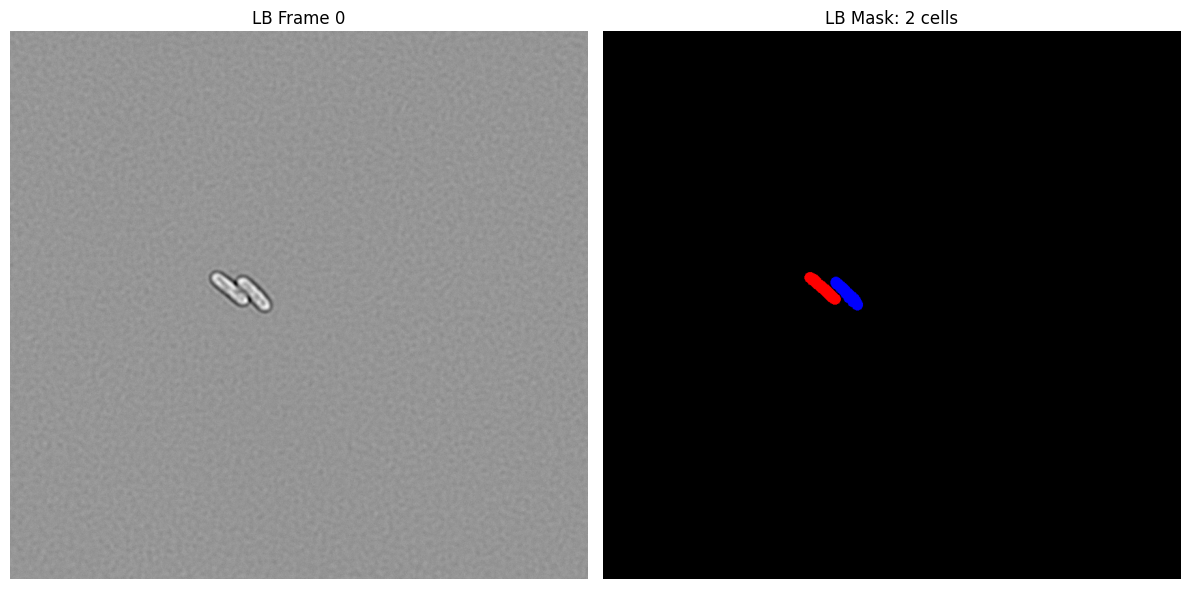


M9 Dataset Analysis:
  Sample frames analyzed: 5
  Average cell count: 2.0
  Cell count range: 2 to 2
  Image shape: (601, 432, 471)
  Mask shape: (601, 432, 471)


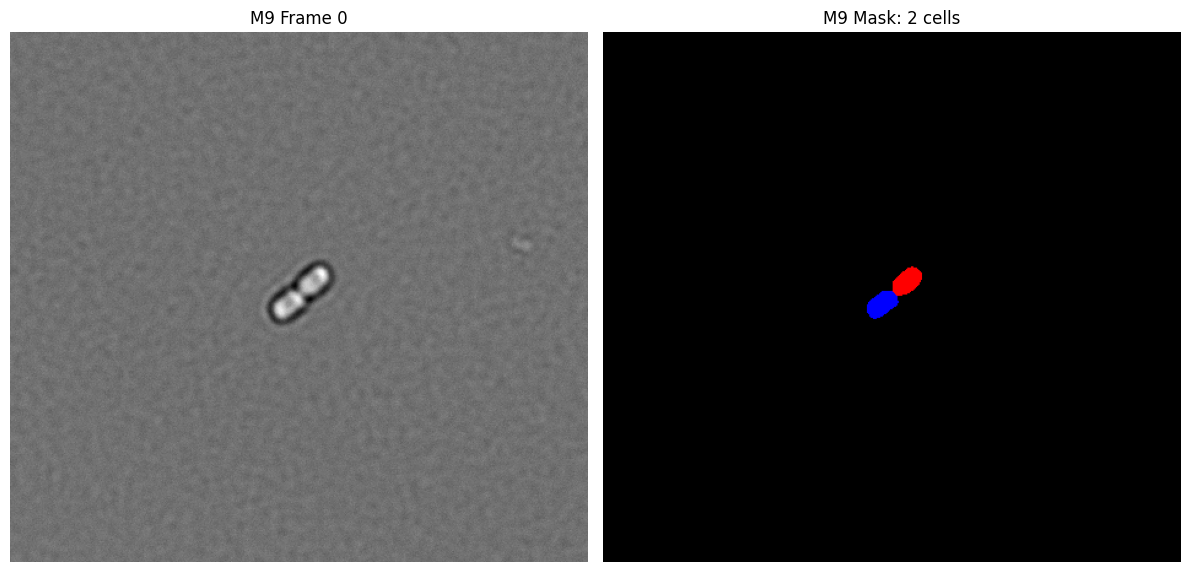


=== Total Dataset Summary ===
Total frames across all datasets: 962
LB frames: 361
M9 frames: 601


In [5]:
def analyze_training_data(data_dir):
    """Analyze training data to understand image characteristics"""
    data_dir = Path(data_dir)
    
    # Find all image/mask pairs
    images = [f for f in data_dir.glob("*.tif") if not f.name.endswith("_masks.tif")]
    
    if not images:
        print("No images found in directory!")
        return
    
    # Sample statistics
    sizes = []
    cell_counts = []
    
    # Sample up to 10 random images for statistics
    sample_imgs = random.sample(images, min(10, len(images)))
    
    for img_path in sample_imgs:
        mask_path = data_dir / f"{img_path.stem}_masks{img_path.suffix}"
        
        if not mask_path.exists():
            continue
            
        # Load image and mask
        img = tifffile.imread(img_path)
        mask = tifffile.imread(mask_path)
        
        # Collect statistics
        sizes.append(img.shape)
        cell_counts.append(len(np.unique(mask)) - 1)  # Subtract 1 for background
    
    print("\n=== Training Data Analysis ===")
    print(f"Total number of images: {len(images)}")
    print(f"Image size range: {min(sizes)} to {max(sizes)}")
    print(f"Average cell count per image: {np.mean(cell_counts):.1f}")
    print(f"Cell count range: {min(cell_counts)} to {max(cell_counts)}")
    
    # Visualize a sample
    if sample_imgs:
        img_path = sample_imgs[0]
        mask_path = data_dir / f"{img_path.stem}_masks{img_path.suffix}"
        
        if mask_path.exists():
            img = tifffile.imread(img_path)
            mask = tifffile.imread(mask_path)
            
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Image: {img_path.name}")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            from skimage.color import label2rgb
            overlay = label2rgb(mask, bg_label=0)
            plt.imshow(overlay)
            plt.title(f"Mask: {len(np.unique(mask))-1} cells")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    return sizes, cell_counts

# Analyze the loaded datasets
if datasets is not None:
    print("\n=== Dataset Analysis ===")
    
    # Analyze each dataset
    for medium, data in datasets.items():
        print(f"\n{medium} Dataset Analysis:")
        images = data['images']
        masks = data['masks']
        
        # Sample a few frames for analysis
        sample_frames = min(5, data['n_frames'])
        cell_counts = []
        
        for i in range(sample_frames):
            mask = masks[i]
            cell_count = len(np.unique(mask)) - 1  # Subtract 1 for background
            cell_counts.append(cell_count)
        
        print(f"  Sample frames analyzed: {sample_frames}")
        print(f"  Average cell count: {np.mean(cell_counts):.1f}")
        print(f"  Cell count range: {min(cell_counts)} to {max(cell_counts)}")
        print(f"  Image shape: {images.shape}")
        print(f"  Mask shape: {masks.shape}")
        
        # Visualize a sample frame
        if data['n_frames'] > 0:
            sample_idx = 0
            img_sample = images[sample_idx]
            mask_sample = masks[sample_idx]
            
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            plt.imshow(img_sample, cmap='gray')
            plt.title(f"{medium} Frame {sample_idx}")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            from skimage.color import label2rgb
            overlay = label2rgb(mask_sample, bg_label=0)
            plt.imshow(overlay)
            plt.title(f"{medium} Mask: {len(np.unique(mask_sample))-1} cells")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    print(f"\n=== Total Dataset Summary ===")
    total_frames = sum(data['n_frames'] for data in datasets.values())
    print(f"Total frames across all datasets: {total_frames}")
    print(f"LB frames: {datasets['LB']['n_frames']}")
    print(f"M9 frames: {datasets['M9']['n_frames']}")
    
else:
    print("❌ Cannot analyze datasets - they were not loaded successfully.")

In [6]:
# Create the actual train/test split
print("\n=== Creating Train/Test Split ===")
print("To create the actual train/test split, uncomment and run the following code:")
print()
print("# Uncomment the lines below to create the train/test split:")
print("# data_stats = organize_training_data(")
print("#     frames_dir,  # Use the individual frames directory")
print("#     output_dir / 'train',")
print("#     output_dir / 'test',")
print("#     train_ratio=0.8,")
print("#     balance=True")
print("# )")
print()
print("# This will:")
print("# 1. Take all individual frame files from frames_dir")
print("# 2. Split them into train (80%) and test (20%) sets")
print("# 3. Balance the datasets between LB and M9 conditions")
print("# 4. Copy the files to the train and test directories")
print()
print("✅ Dataset preparation complete!")
print("The notebook has successfully:")
print("- Loaded LB dataset (original_images.tif + ground_truth.tif)")
print("- Loaded M9 dataset (bf_frames.tif + stacked_masks.tif)")
print("- Created individual frame files")
print("- Provided functions to create train/test splits")
print()
print("Next steps:")
print("1. Uncomment the organize_training_data call above")
print("2. Run the cell to create the actual train/test split")
print("3. Use the resulting train/test directories for model training")


=== Creating Train/Test Split ===
To create the actual train/test split, uncomment and run the following code:

# Uncomment the lines below to create the train/test split:
# data_stats = organize_training_data(
#     frames_dir,  # Use the individual frames directory
#     output_dir / 'train',
#     output_dir / 'test',
#     train_ratio=0.8,
#     balance=True
# )

# This will:
# 1. Take all individual frame files from frames_dir
# 2. Split them into train (80%) and test (20%) sets
# 3. Balance the datasets between LB and M9 conditions
# 4. Copy the files to the train and test directories

✅ Dataset preparation complete!
The notebook has successfully:
- Loaded LB dataset (original_images.tif + ground_truth.tif)
- Loaded M9 dataset (bf_frames.tif + stacked_masks.tif)
- Created individual frame files
- Provided functions to create train/test splits

Next steps:
1. Uncomment the organize_training_data call above
2. Run the cell to create the actual train/test split
3. Use the resulting